# Tópicos Avanzados de Estadística

## Tarea: Bandas de Confianza

### Presentado por: 
- Miguel Ángel Quintero

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras.models import load_model

import scipy.stats as stats
import math

#Tensor Flow

import tensorflow as tf

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
# optimizador
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping



pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 400

In [111]:
# Open Power System Data
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")

In [112]:
# to explicitly convert the date column to type DATETIME
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [113]:
data.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [121]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['Consumption'].values.reshape(-1, 1))
dataset = pd.DataFrame(scaled_data,index=data.index, columns=['scaled'])

In [123]:
## Todos los dataframes se dividen en train y test. Se usa 'CA_1' porque todos los df tienen la misma longitud
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(dataset)]
len_train = len(train)
len_test = len(test)
print(len_train, len_test)

3506 877


In [127]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # el primer lote de datos empieza en la primera observación
    # y toma time_steps  datos.
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [128]:
time_steps = 30

X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)
print(X_train.shape, y_train.shape)

(3476, 30, 1) (3476, 1)


In [153]:
## definimos la estructura del modelo LSTM
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs)
outputs = Dense(1)(x)

# model
model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')

In [155]:
model.summary()

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 60)                14880     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [156]:
model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

In [157]:
history = model.fit(
  X_train, y_train,
  epochs=30,
  batch_size=16,
  validation_split=0.1,
  verbose=1,
  shuffle=False
  )
model.save('modelo_LSTM_BANDAS.h5')

Epoch 1/30
196/196 [==============================] - 5s 17ms/step - loss: 0.0373 - val_loss: 0.0307
Epoch 2/30
196/196 [==============================] - 3s 14ms/step - loss: 0.0293 - val_loss: 0.0290
Epoch 3/30
196/196 [==============================] - 3s 15ms/step - loss: 0.0278 - val_loss: 0.0273
Epoch 4/30
196/196 [==============================] - 4s 18ms/step - loss: 0.0237 - val_loss: 0.0170
Epoch 5/30
196/196 [==============================] - 2s 9ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 6/30
196/196 [==============================] - 4s 22ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 7/30
196/196 [==============================] - 4s 19ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 8/30
196/196 [==============================] - 2s 9ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 9/30
196/196 [==============================] - 4s 21ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 10/30
196/196 [==============================] - 3s 18ms/step - loss: 0.0067 - val_loss

In [158]:
y_pred = model.predict(X_test)

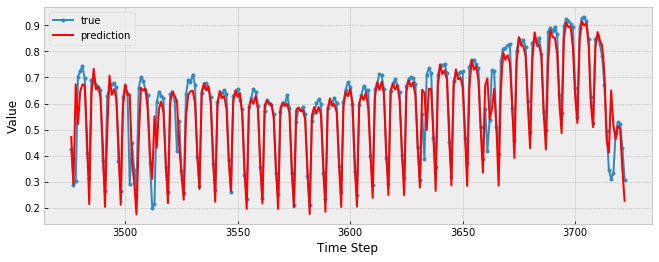

In [159]:
fig = plt.figure(figsize=(24,4))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(y_train), len(y_train) + len(y_test[600:])), y_test[600:], marker='.', label="true")
ax1.plot(np.arange(len(y_train), len(y_train) + len(y_test[600:])), y_pred[600:], 'r', label="prediction")
ax1.set_ylabel('Value')
ax1.set_xlabel('Time Step')

plt.legend()
plt.show()

In [ ]:
from tensorflow.python.keras.backend import eager_learning_phase_scope

In [166]:
def create_dropout_predict_function(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers
    
    Returns
    predict_with_dropout : keras function for predicting with dropout
    """
    
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 
    
    # Create a function to predict with the dropout on
    predict_with_dropout = K.function(model_dropout.inputs, model_dropout.outputs)
    
    return predict_with_dropout

In [161]:
y_test

array([[0.65420395],
       [0.68243476],
       [0.67406965],
       [0.67322553],
       [0.65188838],
       [0.41441097],
       [0.31225257],
       [0.68713163],
       [0.7101824 ],
       [0.73007923],
       [0.73309247],
       [0.66118756],
       [0.40579215],
       [0.30817841],
       [0.66659479],
       [0.71449872],
       [0.71935473],
       [0.70783454],
       [0.67522167],
       [0.42709586],
       [0.32151255],
       [0.67960372],
       [0.71195136],
       [0.71095272],
       [0.67185095],
       [0.63269382],
       [0.30065281],
       [0.29315258],
       [0.65631771],
       [0.72701064],
       [0.73836247],
       [0.73144459],
       [0.68237134],
       [0.42964783],
       [0.32778811],
       [0.69514618],
       [0.77121751],
       [0.80620822],
       [0.80869331],
       [0.7682896 ],
       [0.49503732],
       [0.38826739],
       [0.74948367],
       [0.77674697],
       [0.77128439],
       [0.77508871],
       [0.71791903],
       [0.464

In [194]:
dropout = 0.6
num_iter = 20
num_samples = y_test.shape[0]

path_to_model = "modelo_LSTM_BANDAS.h5"
model_band = load_model(path_to_model)

predict_with_dropout = create_dropout_predict_function(model, dropout)

predictions = np.zeros((num_samples, num_iter))
for i in range(num_iter):
    predictions[:,i] = predict_with_dropout(y_test+[1])[0].reshape(-1)

In [195]:
ci = 0.8
lower_lim = np.quantile(predictions, 0.5-ci/2, axis=1)
upper_lim = np.quantile(predictions, 0.5+ci/2, axis=1)

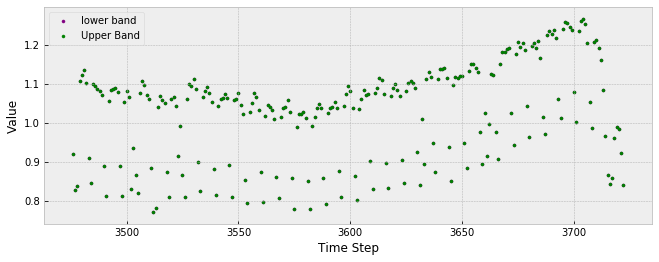

In [204]:
fig = plt.figure(figsize=(24,4))
ax1 = fig.add_subplot(121)
ax1.scatter(np.arange(len(y_train), len(y_train) + len(y_test[600:])),lower_lim[600:],marker='.', color='purple',label="lower band")
ax1.scatter(np.arange(len(y_train), len(y_train) + len(y_test[600:])),upper_lim[600:],marker='.',color='g', label="Upper Band")
# ax1.plot(np.arange(len(y_train), len(y_train) + len(y_test[600:])), y_test[600:], marker='.', label="true")
# ax1.plot(np.arange(len(y_train), len(y_train) + len(y_test[600:])), y_pred[600:], 'r', label="prediction")
ax1.set_ylabel('Value')
ax1.set_xlabel('Time Step')

plt.legend()
plt.show()